# Setup

## Library Installation

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

## Google Drive Connection

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Libraries Import

In [ ]:
import os
import tarfile

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from torchvision.utils import save_image

import albumentations as A
from albumentations.pytorch import ToTensorV2

from torchmetrics.image import StructuralSimilarityIndexMeasure,PeakSignalNoiseRatio

#  Dataset Import
- **Create Dataset Directory**  
  Utilized `os.makedirs()` to create the `/content/datasets` directory.

- **Extract Dataset Archive**  
  Opened the `maps.tar.gz` archive from Google Drive using Python's `tarfile` module and extracted its contents into the `/content/datasets` directory. This step unpacks the dataset for subsequent use.

---

The dataset is a paired image with satellite and map image which looks as:

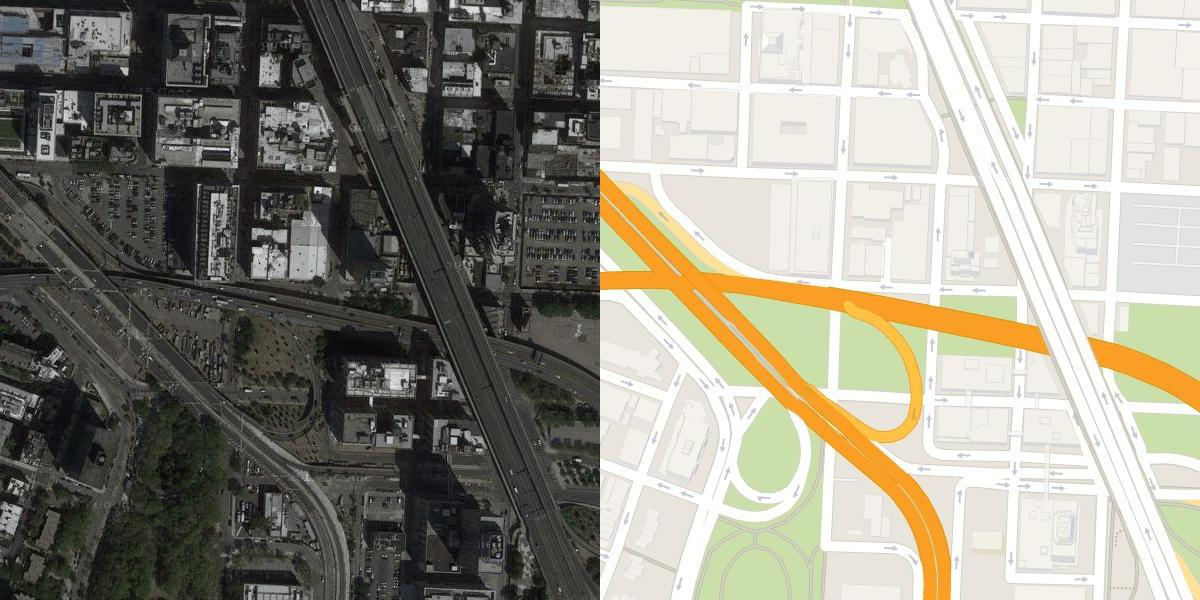

In [ ]:
os.makedirs("/content/datasets",exist_ok=True)
dataset_folder = "/content/datasets"

In [ ]:
with tarfile.open("/content/drive/MyDrive/maps.tar.gz") as tar:
  tar.extractall(dataset_folder)

#  Training Configuration
This cell sets up essential hyperparameters and configurations for training a deep learning model using PyTorch.

- **Device Selection:**  
  Automatically assigns the computation device to `"cuda"` if a GPU is available; otherwise, defaults to `"cpu"`.

- **Data Directories:**  
  - `TRAIN_DIR`: Specifies the path to the training dataset.  
  - `VAL_DIR`: Specifies the path to the validation dataset.

- **Training Parameters:**  
  - `LEARNING_RATE`: Sets the learning rate for the optimizer.  
  - `BATCH_SIZE`: Defines the number of samples per batch.  
  - `NUM_WORKERS`: Sets the number of subprocesses for data loading.  
  - `IMAGE_SIZE`: Specifies the size to which images are resized.  
  - `CHANNELS_IMG`: Defines the number of color channels in the images.  
  - `L1_LAMBDA`: Weight for the L1 loss term.  
  - `LAMBDA_GP`: Weight for the gradient penalty term.  
  - `NUM_EPOCHS`: Specifies the number of training epochs.  
  - `LOAD_MODEL`: Boolean flag to load a pre-trained model.  
  - `SAVE_MODEL`: Boolean flag to save the trained model.

- **Checkpoint Paths:**  
  - `CHECKPOINT_DISC`: Path to save the discriminator model.  
  - `CHECKPOINT_GEN`: Path to save the generator model.

---

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

TRAIN_DIR = "data/train"
VAL_DIR = "data/val"

LEARNING_RATE = 2e-4
BATCH_SIZE = 32 # changed from 16
NUM_WORKERS = 2
IMAGE_SIZE = 256
CHANNELS_IMG = 3
L1_LAMBDA = 100
LAMBDA_GP = 10
NUM_EPOCHS = 50
LOAD_MODEL = True
SAVE_MODEL = True

CHECKPOINT_DISC = "/content/disc.pth.tar"
CHECKPOINT_GEN = "/content/gen.pth.tar"

# Dataset Configuration

## Data Augmentations with Albumentations

The below code cell uses the **Albumentations** library to apply data augmentation.

### Transformation Pipeline

Three transformation pipelines are defined:

### 1. Shared Transformations (Applied to Both Image and Mask)

This pipeline:
1. Resizes both image and mask to 256×256 pixels
2. Applies horizontal flipping with 50% probability

### 2.  Input Image-Only Transformations
This pipeline applies the following additional transformations only to the input image:

1. Horizontal flipping with 50% probability
2. Color jittering with 20% probability (adjusts brightness, contrast, saturation)
3. Normalization to prepare the data for neural networks (transforms pixel values to range [-1, 1])
4. Conversion to PyTorch tensor format

### 3. Mask-Only Transformations
This pipeline:

1. Normalizes the mask data
2. Converts mask to PyTorch tensor format

In [ ]:
both_transform = A.Compose(
    [A.Resize(width=256, height=256),A.HorizontalFlip(p=0.5)], additional_targets={"image0": "image"},
)

transform_only_input = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.ColorJitter(p=0.2),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        ToTensorV2(),
    ]
)

transform_only_mask = A.Compose(
    [
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        ToTensorV2(),
    ]
)

## Dataset Class
The `MapDataset` class is a custom PyTorch dataset designed to load and preprocess paired images from a specified directory.

- **Initialization (`__init__`)**:  
  Takes a root directory path, lists all image files within it, and stores the filenames for later access.

- **Length (`__len__`)**:  
  Returns the total number of image files, enabling iteration over the dataset.

- **Get Item (`__getitem__`)**:  
  For a given index, it:
  1. Loads the image file and converts it to a NumPy array.
  2. Splits the image into two parts horizontally:
     - `input_image`: the left part (all rows, first 600 columns).
     - `target_image`: the right part (all rows, columns from 600 onwards).
  3. Applies joint augmentations (`both_transform`) to both images simultaneously to maintain alignment.
  4. Applies additional transformations (`transform_only_input`) separately on each image.
  5. Returns the processed input-target image pair.


In [ ]:
class MapDataset(Dataset):
  def __init__(self,root_dir):
    super().__init__()
    self.root_dir = root_dir
    self.list_files = os.listdir(self.root_dir)
    print(self.list_files)

  def __len__(self):
    return len(self.list_files)

  def __getitem__(self, index):
    img_file = self.list_files[index]
    img_path = os.path.join(self.root_dir,img_file)
    image = np.array(Image.open(img_path))
    input_image = image[:,:600,:]
    target_image = image[:,600:,:]

    augmentations =  both_transform(image=input_image,image0=target_image)
    input_image, target_image = augmentations["image"], augmentations["image0"]

    input_image = transform_only_input(image=input_image)["image"]
    target_image = transform_only_input(image=target_image)["image"]

    return input_image,target_image

## DataLoader
  The `train_dataset` is created by instantiating the `MapDataset` class with the training data directory (`/content/datasets/maps/train`).  
  The `train_loader` wraps this dataset in a PyTorch `DataLoader` with the following settings:  
  - `batch_size` set to `BATCH_SIZE` for mini-batch training.  
  - `shuffle=True` to randomize the order of samples each epoch, improving model generalization.  
  - `num_workers=NUM_WORKERS` to enable parallel data loading for faster training.

- **Validation Dataset and DataLoader**:  
  The `val_dataset` is similarly created for the validation data directory (`/content/datasets/maps/val`).  
  The `val_loader` uses a batch size of 1 and shuffles the data to evaluate the model on individual samples during validation.

This setup efficiently manages loading and batching of paired image data for both training and validation phases.

In [ ]:
train_dataset = MapDataset(root_dir="/content/datasets/maps/train")
train_loader = DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=NUM_WORKERS)

val_dataset = MapDataset(root_dir="/content/datasets/maps/val")
val_loader = DataLoader(val_dataset,batch_size=1,shuffle=True)

['608.jpg', '1067.jpg', '932.jpg', '990.jpg', '278.jpg', '1021.jpg', '821.jpg', '650.jpg', '227.jpg', '973.jpg', '671.jpg', '986.jpg', '394.jpg', '150.jpg', '604.jpg', '302.jpg', '200.jpg', '297.jpg', '914.jpg', '359.jpg', '330.jpg', '830.jpg', '406.jpg', '255.jpg', '554.jpg', '994.jpg', '749.jpg', '775.jpg', '900.jpg', '124.jpg', '381.jpg', '625.jpg', '512.jpg', '542.jpg', '371.jpg', '738.jpg', '587.jpg', '221.jpg', '636.jpg', '181.jpg', '374.jpg', '758.jpg', '553.jpg', '502.jpg', '68.jpg', '119.jpg', '293.jpg', '480.jpg', '832.jpg', '516.jpg', '230.jpg', '349.jpg', '654.jpg', '1000.jpg', '726.jpg', '421.jpg', '863.jpg', '335.jpg', '346.jpg', '134.jpg', '737.jpg', '612.jpg', '283.jpg', '494.jpg', '6.jpg', '823.jpg', '1055.jpg', '56.jpg', '72.jpg', '907.jpg', '110.jpg', '888.jpg', '506.jpg', '264.jpg', '1053.jpg', '244.jpg', '988.jpg', '161.jpg', '451.jpg', '755.jpg', '883.jpg', '956.jpg', '183.jpg', '885.jpg', '655.jpg', '249.jpg', '594.jpg', '843.jpg', '368.jpg', '1014.jpg', '12.jpg'

# Pix2Pix Architecture
Pix2Pix is a conditional Generative Adversarial Network (cGAN) designed for image-to-image translation tasks. It consists of two main components:

- **Generator:**  
  A U-Net style encoder-decoder network that takes an input image and generates a corresponding output image. The encoder progressively downsamples the input to capture context, while the decoder upsamples and reconstructs the output, using skip connections to preserve spatial details.
  
  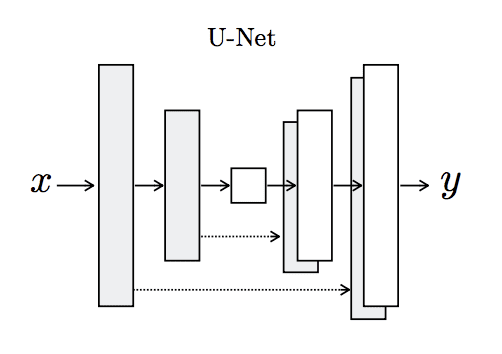

- **Discriminator:**  
  A PatchGAN discriminator that evaluates whether image pairs (input and generated or real target) are real or fake at the patch level, encouraging the generator to produce realistic local details.

  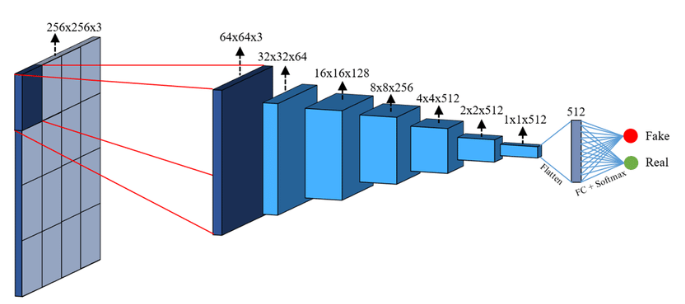

The training involves adversarial loss to make generated images indistinguishable from real ones, combined with an L1 loss to ensure outputs are close to the target images in pixel space. This combination helps Pix2Pix generate high-quality, structurally consistent images for various applications like style transfer, image colorization, and semantic segmentation.

## CNN BLOCK

- Defines a convolutional block as a PyTorch `nn.Module`.
- Applies a 2D convolution with:
  - Kernel size of 4
  - Specified stride (default is 2) for downsampling
  - No bias term
- Follows convolution with batch normalization to stabilize training.
- Uses a ReLU activation function ).
- The `forward` method passes input through this sequence, producing feature maps for further processing.

In [ ]:
class CNNLayer(nn.Module):
  def __init__(self,input_channel,output_channel,stride =2):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(input_channel,output_channel,4,stride,bias=False,padding_mode="reflect"),
        nn.BatchNorm2d(output_channel),
        nn.ReLU(0.2)
    )

  def forward(self,x):
    return self.conv(x)

## Discriminator
- Implements a discriminator network as a PyTorch `nn.Module`.
- **Input:** Concatenates two images (`x` and `y`) along the channel dimension, doubling input channels.
- **Initial Layer:**  
  - Applies a convolution with stride 2 for downsampling, followed by a ReLU activation.
- **Intermediate Layers:**  
  - Stacks multiple `CNNLayer` blocks with increasing feature sizes (64 → 128 → 256 → 512).  
  - Uses stride 2 for downsampling except for the last layer (stride 1).
- **Final Layer:**  
  - A convolution producing a single-channel output, indicating real/fake prediction scores.
- **Forward Pass:**  
  - Concatenates input and target images, passes through initial and intermediate layers, and outputs a feature map representing discriminator confidence.
  
This architecture is typical for PatchGAN discriminators used in image-to-image translation tasks.

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, input_channel=3,features=[64,128,256,512]):
    super().__init__()
    self.initial = nn.Sequential(
        nn.Conv2d(input_channel*2,features[0],kernel_size=4,stride=2,padding=1,padding_mode="reflect"),
        nn.ReLU(0.2)
    )

    layers = []
    input_channel = features[0]
    for feature in features[1:]:
      layers.append(CNNLayer(input_channel,feature,stride=1 if feature==features[-1] else 2)),
      input_channel =  feature

    layers.append(
        nn.Conv2d(input_channel,1,kernel_size=4,stride=1,padding=1,padding_mode="reflect")
    )
    self.model = nn.Sequential(*layers)

  def forward(self,x,y):
    x = torch.cat([x,y],dim=1) # along the channel concatenation
    x = self.initial(x)
    x = self.model(x)
    return x

## Encoder / Decoder Block
- Defines a flexible convolutional block as a PyTorch `nn.Module` for Encoder(Upsampling) and Decoder(Downsampling).
- **Downsampling or Upsampling:**  
  - Uses `nn.Conv2d` with stride 2 for downsampling if `down=True`.  
  - Uses `nn.ConvTranspose2d` with stride 2 for upsampling if `down=False`.
- **Batch Normalization:**  
  - Applies batch normalization after convolution for stable training.
- **Activation:**  
  - Uses ReLU or LeakyReLU (with 0.2 negative slope) based on the `activation` parameter.
- **Dropout:**  
  - Optionally applies dropout with 0.5 probability if `dropout=True` to reduce overfitting.
- **Forward Pass:**  
  - Passes input through convolution, normalization, activation, and optionally dropout.

This block is used to make encoder-decoder architectures.

In [ ]:
class Block(nn.Module):
  def __init__(self,input_channels,output_channels,down=True,activation="relu",dropout=False):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(input_channels,output_channels,4,2,1,bias=False,padding_mode="reflect")
        if down
        else
        nn.ConvTranspose2d(input_channels,output_channels,4,2,1,bias=False),
        nn.BatchNorm2d(output_channels),
        nn.ReLU() if activation=="relu" else nn.LeakyReLU(0.2)
    )
    self.use_dropout = dropout
    self.dropout = nn.Dropout(0.5)

  def forward(self,x):
    x = self.conv(x)
    return self.dropout(x) if self.use_dropout else x

## Generator
- Implements a U-Net style generator as a PyTorch `nn.Module` for image-to-image translation.
- **Downsampling Path:**  
  - Starts with an initial convolution and LeakyReLU activation.  
  - Uses multiple `Block` modules with downsampling (`Conv2d`), increasing feature channels progressively (64 → 512).  
  - Extracts hierarchical features while reducing spatial dimensions.
- **Bottleneck:**  
  - A convolutional layer with ReLU that compresses features to a 1x1 spatial size, serving as the network’s deepest representation.
- **Upsampling Path:**  
  - Uses `Block` modules with upsampling (`ConvTranspose2d`) and ReLU activation.  
  - Applies dropout selectively in early upsampling layers to prevent overfitting.  
  - Performs skip connections by concatenating corresponding downsampling outputs to preserve spatial details.
- **Final Layer:**  
  - A transposed convolution followed by `Tanh` activation to generate the output image with values scaled between -1 and 1.
- **Forward Pass:**  
  - Passes input through downsampling blocks, bottleneck, and upsampling blocks with skip connections, reconstructing a high-quality output image.


In [ ]:
class Generator(nn.Module):
  def __init__(self,input_channels=3,features=64):
    super().__init__()
    self.initial_down = nn.Sequential(
        nn.Conv2d(input_channels,features,4,2,1,padding_mode="reflect"),
        nn.LeakyReLU(0.2),
    )
    self.down1 = Block(features,features*2,down=True,activation="leaky",dropout=False)
    self.down2 = Block(features*2,features*4,down=True,activation="leaky",dropout=False)
    self.down3 = Block(features*4,features*8,down=True,activation="leaky",dropout=False)
    self.down4 = Block(features*8,features*8,down=True,activation="leaky",dropout=False)
    self.down5 = Block(features*8,features*8,down=True,activation="leaky",dropout=False)
    self.down6 = Block(features*8,features*8,down=True,activation="leaky",dropout=False)

    self.bottleneck = nn.Sequential(
        nn.Conv2d(features*8,features*8,4,2,1,padding_mode="reflect"),
        nn.ReLU() # 1 X 1
    )

    self.up1 = Block(features*8,features*8,down=False,activation="relu",dropout=True)
    self.up2 = Block(features*8*2,features*8,down=False,activation="relu",dropout=True)
    self.up3 = Block(features*8*2,features*8,down=False,activation="relu",dropout=True)
    self.up4 = Block(features*8*2,features*8,down=False,activation="relu",dropout=False)
    self.up5 = Block(features*8*2,features*4,down=False,activation="relu",dropout=False)
    self.up6 = Block(features*4*2,features*2,down=False,activation="relu",dropout=False)
    self.up7 = Block(features*2*2,features,down=False,activation="relu",dropout=False)
    self.final_up = nn.Sequential(
        nn.ConvTranspose2d(features*2,input_channels,kernel_size=4,stride=2,padding=1),
        nn.Tanh()
    )

  def forward(self,x):
    d1 = self.initial_down(x)
    d2 = self.down1(d1)
    d3 = self.down2(d2)
    d4 = self.down3(d3)
    d5 = self.down4(d4)
    d6 = self.down5(d5)
    d7 = self.down6(d6)

    bottleneck = self.bottleneck(d7)

    up1 = self.up1(bottleneck)
    up2 = self.up2(torch.cat([up1,d7],1))
    up3 = self.up3(torch.cat([up2,d6],1))
    up4 = self.up4(torch.cat([up3,d5],1))
    up5 = self.up5(torch.cat([up4,d4],1))
    up6 = self.up6(torch.cat([up5,d3],1))
    up7 = self.up7(torch.cat([up6,d2],1))
    return self.final_up(torch.cat([up7,d1], 1))

# Model Configurations
- **Model Instantiation:**  
  - Creates instances of the `Discriminator` and `Generator` classes with 3 input channels (e.g., RGB images).  
  - Moves both models to the specified device (`DEVICE`), such as GPU or CPU.

- **Optimizers:**  
  - Uses Adam optimizer for both discriminator and generator with the same learning rate (`LEARNING_RATE`) and betas `(0.5, 0.999)`, which are common settings for stable GAN training.

- **Loss Functions:**  
  - `BCEWithLogitsLoss` (Binary Cross-Entropy with logits) for adversarial loss, used to distinguish real vs. fake images.  
  - `L1Loss` for pixel-wise reconstruction loss, encouraging the generator to produce outputs close to targets.



In [ ]:
disc = Discriminator(input_channel=3).to(DEVICE)
gen = Generator(input_channels=3).to(DEVICE)
opt_disc = optim.Adam(disc.parameters(),lr=LEARNING_RATE,betas=(0.5,0.999))
opt_gen = optim.Adam(gen.parameters(),lr=LEARNING_RATE,betas=(0.5,0.999))
BCE = nn.BCEWithLogitsLoss()
L1_LOSS = nn.L1Loss()


## Mixed Precision Training Setup

- Initializes two `GradScaler` objects from PyTorch's automatic mixed precision (AMP) module:
  - `g_scaler` for scaling gradients during generator training.
  - `d_scaler` for scaling gradients during discriminator training.
- These scalers help prevent underflow in float16 precision by dynamically scaling loss values, enabling faster and more memory-efficient training on compatible GPUs.

In [ ]:
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

<ipython-input-15-7522990ed467>:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  g_scaler = torch.cuda.amp.GradScaler()
<ipython-input-15-7522990ed467>:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  d_scaler = torch.cuda.amp.GradScaler()


## Utility Functions

In [ ]:
def save_some_examples(gen, val_loader, epoch, folder):
    x, y = next(iter(val_loader))
    x, y = x.to(DEVICE), y.to(DEVICE)
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x)
        y_fake = y_fake * 0.5 + 0.5  # remove normalization#
        save_image(y_fake, folder + f"/y_gen_{epoch}.png")
        save_image(x * 0.5 + 0.5, folder + f"/input_{epoch}.png")
        if epoch == 1:
            save_image(y * 0.5 + 0.5, folder + f"/label_{epoch}.png")
    gen.train()


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

**Checkpoint Loading:**  
  - If `LOAD_MODEL` is `True`, loads saved model weights and optimizer states from checkpoint files (`CHECKPOINT_GEN` and `CHECKPOINT_DISC`) to resume training from a previous state.

In [ ]:
if LOAD_MODEL:
  load_checkpoint(CHECKPOINT_GEN,gen,opt_gen,LEARNING_RATE)
  load_checkpoint(CHECKPOINT_DISC,disc,opt_disc,LEARNING_RATE)

=> Loading checkpoint
=> Loading checkpoint


# Train Model

## Training Function
- **Purpose:**  
  Defines one epoch of training for the Pix2Pix, updating both discriminator and generator.

- **Inputs:**  
  - `disc`, `gen`: discriminator and generator models.  
  - `train_loader`: data loader for training batches.  
  - `opt_disc`, `opt_gen`: optimizers for discriminator and generator.  
  - `L1_LOSS`, `BCE`: loss functions for reconstruction and adversarial losses.  
  - `g_scaler`, `d_scaler`: gradient scalers for mixed precision training.

- **Process:**  
  - Iterates over batches `(x, y)` from `train_loader`, moving data to the device.  
  - **Discriminator Training:**  
    - Generates fake images `y_fake` from input `x`.  
    - Computes discriminator outputs on real pairs `(x, y)` and fake pairs `(x, y_fake)`.  
    - Calculates adversarial losses for real and fake, averages them.  
    - Uses AMP (`autocast`) and gradient scaling to backpropagate and update discriminator weights.
  - **Generator Training:**  
    - Recomputes discriminator output on fake images.  
    - Calculates adversarial loss encouraging generator to fool discriminator.  
    - Adds L1 loss weighted by `L1_LAMBDA` for pixel-level accuracy.  
    - Uses AMP and gradient scaling to backpropagate and update generator weights.

- **Returns:**  
  - Average discriminator and generator losses for the epoch.

This function efficiently trains the Pix2Pix using mixed precision for faster computation and reduced memory usage.

In [ ]:
def train_fn(disc,gen,train_loader,opt_disc,L1_LOSS,BCE,g_scaler,d_scaler):
  loop = tqdm(train_loader,leave=True)
  batch_d_loss = []
  batch_g_loss = []
  for idx, (x,y) in enumerate(loop):
    x,y = x.to(DEVICE),y.to(DEVICE)
    # Train discriminator
    with torch.cuda.amp.autocast():
      y_fake = gen(x)
      D_real = disc(x,y)
      D_fake = disc(x,y_fake.detach())
      D_real_loss = BCE(D_real,torch.ones_like(D_real))
      D_fake_loss = BCE(D_fake,torch.zeros_like(D_fake))
      D_loss = (D_real_loss + D_fake_loss) / 2
    disc.zero_grad()
    d_scaler.scale(D_loss).backward()
    d_scaler.step(opt_disc)
    d_scaler.update()
    # train generator
    with torch.cuda.amp.autocast():
      D_fake = disc(x,y_fake)
      G_fake_loss = BCE(D_fake,torch.ones_like(D_fake))
      L1 = L1_LOSS(y_fake,y) * L1_LAMBDA
      G_loss = G_fake_loss + L1
    opt_gen.zero_grad()
    g_scaler.scale(G_loss).backward()
    g_scaler.step(opt_gen)
    g_scaler.update()
    batch_d_loss.append(D_loss.item())
    batch_g_loss.append(G_loss.item())

    loop.set_postfix(
              D_loss=D_loss.item(),
              G_loss=G_loss.item(),
    )

  return np.mean(batch_d_loss),np.mean(batch_g_loss)

## Training Loop
- Iterates over the specified number of epochs (`NUM_EPOCHS`).
- **Training Epoch:**
  - Calls the `train_fn` to perform one training epoch, updating the generator and discriminator.
  - Appends the returned training losses (`train_d_loss`, `train_g_loss`) to lists for later analysis.
- **Model Checkpointing:**
  - If `SAVE_MODEL` is enabled and the current epoch is a multiple of 5:
    - Saves the generator and discriminator models' states along with their optimizers' states to checkpoint files.
- **Validation and Visualization:**
  - Calls `save_some_examples` to generate and save sample output images using the generator and validation dataset (`val_loader`), allowing visual monitoring of training progress.

In [ ]:
train_d_losses = []
train_g_losses = []

In [ ]:
for epoch in range(NUM_EPOCHS):
  train_d_loss, train_g_loss = train_fn(disc,gen,train_loader,opt_disc,L1_LOSS,BCE,g_scaler,d_scaler)
  train_d_losses.append(train_d_loss)
  train_g_losses.append(train_g_loss)


  if SAVE_MODEL and epoch % 5 == 0:
    save_checkpoint(gen,opt_gen,filename=CHECKPOINT_GEN)
    save_checkpoint(disc,opt_disc,filename=CHECKPOINT_DISC)

  save_some_examples(gen,val_loader,epoch,folder="/content/evaluation")

  0%|          | 0/35 [00:00<?, ?it/s]<ipython-input-19-686eb05674ca>:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-19-686eb05674ca>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 35/35 [00:14<00:00,  2.46it/s, D_loss=0.146, G_loss=19]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 35/35 [00:12<00:00,  2.73it/s, D_loss=0.271, G_loss=13.7]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 35/35 [00:13<00:00,  2.63it/s, D_loss=0.285, G_loss=13.8]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 35/35 [00:13<00:00,  2.59it/s, D_loss=0.999, G_loss=18.2]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 35/35 [00:12<00:00,  2.70it/s, D_loss=0.394, G_loss=14.7]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 35/35 [00:13<00:00,  2.69it/s, D_loss=0.101, G_loss=17.2]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 35/35 [00:12<00:00,  2.71it/s, D_loss=0.622, G_loss=17.6]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 35/35 [00:13<00:00,  2.62it/s, D_loss=0.0596, G_loss=22.3]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 35/35 [00:13<00:00,  2.62it/s, D_loss=0.0796, G_loss=17.1]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 35/35 [00:13<00:00,  2.66it/s, D_loss=0.0762, G_loss=18.9]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 35/35 [00:12<00:00,  2.70it/s, D_loss=0.263, G_loss=20.8]


# Evaluation

## Loss Curve
- **Functionality:**  
  Plots the training losses of the discriminator and generator over epochs to visualize training progress.

- **Details:**  
  - Creates a figure with two side-by-side subplots.  
  - Left subplot shows the discriminator’s training loss across epochs.  
  - Right subplot shows the generator’s training loss across epochs.  
  
- **Usage:**  
  Called after training completes to help analyze how the losses evolved, which is useful for diagnosing model performance and convergence.

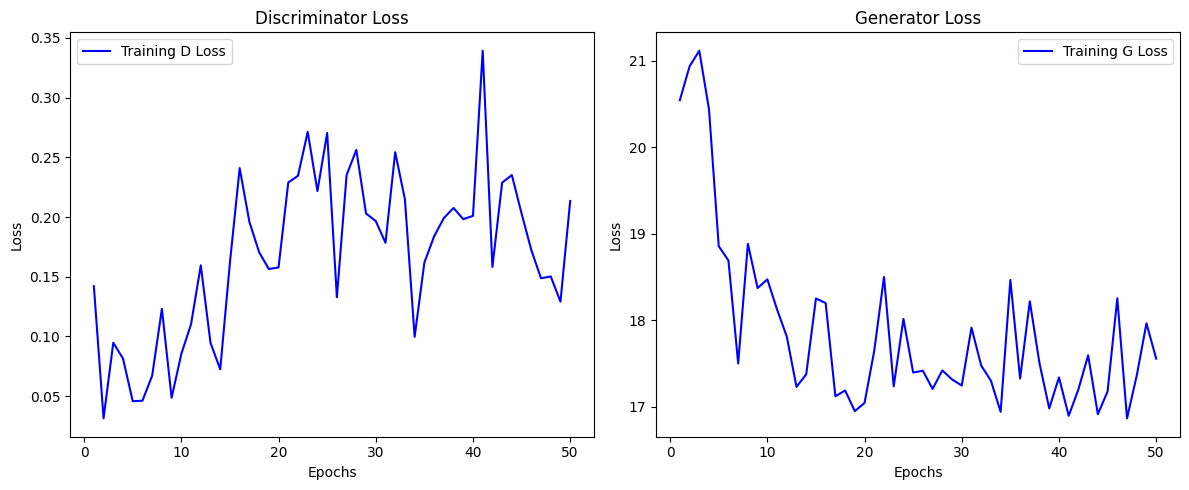

In [ ]:
def plot_losses(train_d_losses, train_g_losses):
    epochs = range(1, len(train_d_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Discriminator loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_d_losses, 'b-', label='Training D Loss')
    plt.title('Discriminator Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Generator loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_g_losses, 'b-', label='Training G Loss')
    plt.title('Generator Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig('pix2pix_training_validation_loss.png')
    plt.show()

# Call the plot function after training is complete
plot_losses(train_d_losses, train_g_losses)

## SSIM and PSNR Score
- Sets the generator model to evaluation mode using `gen.eval()` before calculating the scores.
- Initializes two image quality metrics on the device:
  - **SSIM (Structural Similarity Index Measure):** Measures perceptual similarity between generated and target images, focusing on structural information.
  - **PSNR (Peak Signal-to-Noise Ratio):** Quantifies the reconstruction quality by comparing pixel-wise differences.
- Iterates over the validation dataset (`val_loader`), moving input and target images to the device.
- Generates fake images from input images using the generator.
- Computes SSIM and PSNR between generated and ground truth images, appending the results to lists for later analysis.

This process provides objective metrics to assess the visual fidelity and quality of the generated images during validation.

In [ ]:
gen.eval()
ssim_vals = []
psnr_vals = []
ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(DEVICE)
psnr = PeakSignalNoiseRatio().to(DEVICE)
with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(DEVICE), y_val.to(DEVICE)

            # Generate fake images
            y_fake = gen(x_val)

            # Calculate SSIM and PSNR
            ssim_vals.append(ssim(y_fake,y_val))
            psnr_vals.append(psnr(y_fake,y_val))


In [ ]:
avg_ssim = np.mean([ssim_score.item() for ssim_score in ssim_vals])
avg_psnr = np.mean([psnr_score.item() for psnr_score in psnr_vals])

print(f"The average SSIM score is {avg_ssim}")
print(f"The average PSNR score is {avg_psnr}")


The average SSIM score is 0.571642573218528
The average PSNR score is 26.781124308026772
